# Simple Baseline Analysis for Positive Bag MIL Model
# 복수 작성자 필기 문서에서 서로 다른 작성자의 윈도우를 간단하게 시각화하는 베이스라인

이 노트북은 학습된 AttentionMIL 모델에서 Positive로 예측된 bag의 attention 패턴을 **한 장 그림**으로 간단하게 분석합니다.
복잡한 통계 분석 대신, 실제 필기 이미지를 통해 "다른 손"을 직관적으로 확인하는 것이 목적입니다.

In [1]:
# 1. 환경 설정 및 필요 라이브러리 임포트

import os
import sys
import pickle
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
from tqdm import tqdm
from scipy.stats import kendalltau, spearmanr
from sklearn.metrics import accuracy_score, roc_auc_score
import warnings
warnings.filterwarnings('ignore')

# GPU 설정
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '3'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# 시드 고정
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# 이미지 경로 설정
IMAGE_BASE_DIR = '/workspace/MIL/data/raw/csafe_version5_xai_train'

Using device: cuda


In [2]:
# 2. 모델 정의 (stage3_baseline.ipynb와 동일)

class AttentionMIL(nn.Module):
    def __init__(self, input_dim=256, hidden_dim=128, dropout_p=0.1):
        super().__init__()
        self.instance_fc = nn.Linear(input_dim, hidden_dim)
        self.dropout = nn.Dropout(dropout_p)
        self.att_fc1 = nn.Linear(hidden_dim, hidden_dim)
        self.att_fc2 = nn.Linear(hidden_dim, 1)
        self.classifier = nn.Linear(hidden_dim, 1)
        self._init_weights()
        
    def _init_weights(self):
        # He initialization for layers followed by ReLU
        nn.init.kaiming_uniform_(self.instance_fc.weight, nonlinearity='relu')
        nn.init.zeros_(self.instance_fc.bias)
        nn.init.xavier_uniform_(self.att_fc1.weight)
        nn.init.zeros_(self.att_fc1.bias)
        nn.init.xavier_uniform_(self.att_fc2.weight)
        nn.init.zeros_(self.att_fc2.bias)
        nn.init.xavier_uniform_(self.classifier.weight)
        nn.init.zeros_(self.classifier.bias)
        
    def forward(self, x):
        h = torch.relu(self.instance_fc(x))
        h = self.dropout(h)
        a = torch.tanh(self.att_fc1(h))
        a = self.att_fc2(a).squeeze(-1)
        weights = torch.softmax(a, dim=1)
        bag_repr = torch.sum(weights.unsqueeze(-1) * h, dim=1)
        bag_repr = self.dropout(bag_repr)
        logits = self.classifier(bag_repr).squeeze(-1)
        return logits, weights

In [3]:
# 3. 데이터 로드 및 stage3_baseline 모델 호환

# Bag 데이터 로드
embedding_margin = '0.4'
bags_dir = '/workspace/MIL/data/processed/bags'
test_pkl = os.path.join(bags_dir, f'bags_arcface_margin_{embedding_margin}_50p_random_test.pkl')

print('Loading test bag data...')
with open(test_pkl, 'rb') as f:
    test_data = pickle.load(f)

# Instance mean 계산 함수
def to_instance_means(bags):
    return [bag.mean(axis=1).astype(np.float32) for bag in bags]

test_features = to_instance_means(test_data['bags'])
test_labels = test_data['labels']

# 메타데이터 처리 - test_data에 metadata가 포함되어 있는지 확인
if 'metadata' in test_data:
    metadata = test_data['metadata']
    print('Metadata found in bag data')
else:
    print('Warning: No metadata found. Creating empty metadata.')
    metadata = [{} for _ in range(len(test_labels))]

print(f'Test bags: {len(test_labels)}')
print(f'Positive bags: {sum(test_labels)}, Negative bags: {len(test_labels) - sum(test_labels)}')

# stage3_baseline에서 학습된 모델 로드
model_path = 'best_attention_mil_final.pth'
print(f'Loading stage3 baseline model from {model_path}...')

model = AttentionMIL(input_dim=256, hidden_dim=128, dropout_p=0.1).to(device)
if os.path.exists(model_path):
    model.load_state_dict(torch.load(model_path, map_location=device))
    print('Stage3 baseline model loaded successfully!')
else:
    print(f'Warning: Model file {model_path} not found. Using random initialization.')
    print('Make sure you have run stage3_baseline.ipynb first to train the model.')
    
model.eval()
print(model)

Loading test bag data...
Metadata found in bag data
Test bags: 1200
Positive bags: 600, Negative bags: 600
Loading stage3 baseline model from best_attention_mil_final.pth...
Stage3 baseline model loaded successfully!
AttentionMIL(
  (instance_fc): Linear(in_features=256, out_features=128, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (att_fc1): Linear(in_features=128, out_features=128, bias=True)
  (att_fc2): Linear(in_features=128, out_features=1, bias=True)
  (classifier): Linear(in_features=128, out_features=1, bias=True)
)


In [4]:
# 4. 인스턴스 내 작성자 구분 시각화 함수들 (수정된 버전)

def _predict_att(model, bag_tensor):
    model.eval()
    with torch.no_grad():
        x = torch.tensor(bag_tensor, dtype=torch.float32).unsqueeze(0).to(device)
        logits, att = model(x)
        prob = torch.sigmoid(logits).item()
        att = att.squeeze(0).detach().cpu().numpy()
    return prob, att

def _analyze_instance_composition(inst_meta):
    """인스턴스 내 작성자 구성 분석"""
    if 'writer_ids' not in inst_meta or not inst_meta['writer_ids']:
        return None, []
    
    writer_ids = inst_meta['writer_ids']
    unique_writers = list(dict.fromkeys(writer_ids))  # 순서 유지하면서 중복 제거
    
    # 각 단어별 작성자 정보
    word_writers = []
    for i, w_id in enumerate(writer_ids):
        word_writers.append(w_id)
    
    return unique_writers, word_writers

def _writer_palette(wA, wB, w):
    """작성자별 색상 및 태그 반환"""
    if w == wA: return 'blue', 'A'
    if w == wB: return 'red',  'B'  
    return 'gray', 'U'

def _draw_instance_row_with_word_colors(inst_meta, wA, wB, title, image_base, axarr):
    """인스턴스 내 각 단어별로 작성자에 따른 색상 적용"""
    unique_writers, word_writers = _analyze_instance_composition(inst_meta)
    paths = inst_meta.get('word_paths', [])
    
    for k in range(5):
        ax = axarr[k]
        
        # 해당 단어의 작성자 확인
        word_writer = word_writers[k] if k < len(word_writers) else None
        color, tag = _writer_palette(wA, wB, word_writer) if word_writer else ('gray', 'U')
        
        # 이미지 또는 플레이스홀더 표시
        fp = os.path.join(image_base, paths[k]) if (paths and k < len(paths) and paths[k]) else None
        if fp and os.path.exists(fp):
            try:
                img = Image.open(fp).convert('RGB')
                ax.imshow(img)
            except:
                ax.text(0.5,0.5,f'W{k+1}\\n{tag}',ha='center',va='center', fontsize=8)
                ax.set_facecolor('#e0e0e0')
        else:
            ax.text(0.5,0.5,f'W{k+1}\\n{tag}',ha='center',va='center', fontsize=8)
            ax.set_facecolor('#f5f5f5')
        
        # 단어별 작성자에 따른 테두리 색상
        for sp in ax.spines.values():
            sp.set_edgecolor(color)
            sp.set_linewidth(3)
        ax.set_xticks([])
        ax.set_yticks([])
    
    axarr[0].set_ylabel(title, rotation=0, ha='right', va='center', fontsize=9)

def _get_instance_writer_summary(inst_meta):
    """인스턴스 내 작성자 구성 요약 (예: A:2,B:3)"""
    unique_writers, word_writers = _analyze_instance_composition(inst_meta)
    if not unique_writers:
        return "Unknown"
    
    from collections import Counter
    counts = Counter(word_writers)
    summary = []
    
    # A, B 순서로 정렬
    for w in sorted(unique_writers):
        tag = 'A' if w == unique_writers[0] else 'B'
        summary.append(f"{tag}:{counts[w]}")
    
    return ",".join(summary)

def pick_positive_bag_indices(model, features, labels, metadata, threshold=0.5, topn=1):
    # 예측이 Positive(=정답 1, 예측 1)인 bag 중 확률 높은 순
    probs = []
    for i in range(len(labels)):
        p,_ = _predict_att(model, features[i])
        probs.append(p)
    probs = np.array(probs)
    correct_pos = [i for i in range(len(labels)) if labels[i]==1 and probs[i]>=threshold]
    if not correct_pos: return []
    order = np.argsort(probs[correct_pos])[::-1]
    return [correct_pos[i] for i in order[:topn]]

def quick_positive_report_with_word_colors(bag_idx, model, features, labels, metadata,
                          image_base=IMAGE_BASE_DIR, threshold=0.5, save_dir='quick_reports'):
    os.makedirs(save_dir, exist_ok=True)
    bag = features[bag_idx]            # (10, D) — instance means
    meta = metadata[bag_idx]           # instances/word_paths 포함
    prob, att = _predict_att(model, bag)

    # 전체 bag의 작성자 두 명 파악
    all_writers = []
    for inst in meta.get('instances', []):
        unique_writers, _ = _analyze_instance_composition(inst)
        if unique_writers:
            all_writers.extend(unique_writers)
    uniq = list(dict.fromkeys(all_writers))[:2]  # 보이는 순서로 2명
    if len(uniq) < 2:
        print(f"[Bag {bag_idx}] 두 작성자 식별 실패(메타 부족)."); return

    wA, wB = uniq[0], uniq[1]

    # 각 작성자가 주도하는 인스턴스 중 attention 높은 것 선택
    instances_info = []
    for i, inst in enumerate(meta.get('instances', [])):
        unique_writers, word_writers = _analyze_instance_composition(inst)
        if unique_writers:
            from collections import Counter
            counts = Counter(word_writers)
            # 과반수 작성자 결정
            dominant_writer = max(counts, key=counts.get) if counts else None
            instances_info.append((i, dominant_writer, counts))
    
    # A, B 각각의 주도 인스턴스 중 attention 높은 것 선택
    idxA = [info[0] for info in instances_info if info[1] == wA]
    idxB = [info[0] for info in instances_info if info[1] == wB]
    
    if not idxA or not idxB:
        print(f"[Bag {bag_idx}] 두 작성자 주도 윈도우가 충분치 않음."); return
    
    topA = idxA[int(np.argmax(att[idxA]))]
    topB = idxB[int(np.argmax(att[idxB]))]

    # 그림 구성
    fig = plt.figure(figsize=(12, 6))
    fig.suptitle(f"Bag #{bag_idx}  True=Forged, Pred={'Forged' if prob>=threshold else 'Genuine'}  "
                 f"(p={prob:.3f}, thr={threshold:.2f})", fontsize=12, fontweight='bold')

    # 1행: Writer A 주도 인스턴스
    ax_row1 = [plt.subplot(2,5,1+k) for k in range(5)]
    inst_A = meta['instances'][topA]
    comp_A = _get_instance_writer_summary(inst_A)
    _draw_instance_row_with_word_colors(inst_A, wA, wB,
                       title=f"A-dom inst={topA}\\natt={att[topA]:.3f}\\n({comp_A})",
                       image_base=image_base, axarr=ax_row1)

    # 2행: Writer B 주도 인스턴스  
    ax_row2 = [plt.subplot(2,5,6+k) for k in range(5)]
    inst_B = meta['instances'][topB]
    comp_B = _get_instance_writer_summary(inst_B)
    _draw_instance_row_with_word_colors(inst_B, wA, wB,
                       title=f"B-dom inst={topB}\\natt={att[topB]:.3f}\\n({comp_B})",
                       image_base=image_base, axarr=ax_row2)

    plt.tight_layout(rect=[0,0,1,0.92])
    out_path = os.path.join(save_dir, f"bag_{bag_idx}_word_colors.png")
    plt.savefig(out_path, dpi=150, bbox_inches='tight'); plt.show()
    print(f"✓ saved: {out_path}")

print("✓ 인스턴스 내 작성자별 단어 구분 시각화 함수들이 로드되었습니다.")

✓ 인스턴스 내 작성자별 단어 구분 시각화 함수들이 로드되었습니다.


🔍 확신 높은 Positive bag 자동 선택 후 단어별 작성자 구분 리포트 생성...
선택된 bag: 1182 (확률 높은 Positive bag)


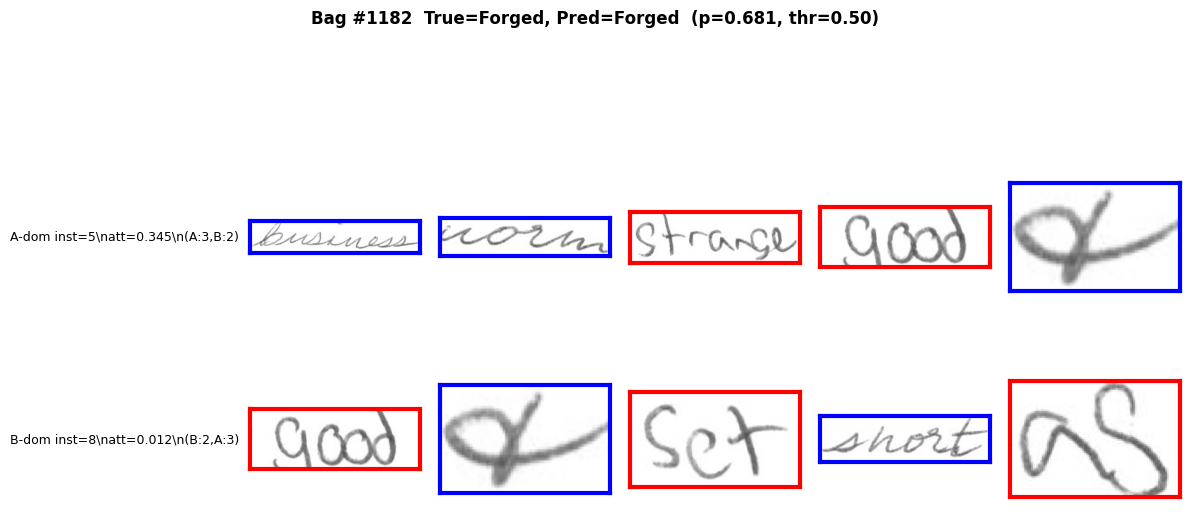

✓ saved: quick_reports/bag_1182_word_colors.png

📊 Bag 1182 요약:
   - 예측 확률: 0.6806
   - 실제 라벨: Forged (복수 작성자)
   - Top-3 attention: [0.34547573 0.2245752  0.20127389]

🔍 인스턴스별 작성자 구성:
   - Instance 0: A:3,B:2, attention: 0.0012
   - Instance 1: B:3,A:2, attention: 0.1772
   - Instance 2: A:4,B:1, attention: 0.0285
   - Instance 3: B:3,A:2, attention: 0.2013
   - Instance 4: A:3,B:2, attention: 0.2246

💡 해석:
   - 각 단어별로 파란 테두리(A) vs 빨간 테두리(B)로 작성자 구분
   - A-dom: 작성자 A가 과반수인 인스턴스, B-dom: 작성자 B가 과반수인 인스턴스
   - (A:2,B:3) 형식으로 해당 인스턴스 내 작성자별 단어 수 표시
   - 하나의 윈도우 내에서도 작성자가 바뀌는 전환점을 확인 가능


In [5]:
# 5. 인스턴스 내 작성자별 단어 구분 시각화 실행

print("🔍 확신 높은 Positive bag 자동 선택 후 단어별 작성자 구분 리포트 생성...")

# 확신 높은 Positive bag 1개 자동 선택
picked = pick_positive_bag_indices(model, test_features, test_labels, metadata, threshold=0.5, topn=1)

if picked:
    bag_idx = picked[0]
    print(f"선택된 bag: {bag_idx} (확률 높은 Positive bag)")
    
    # 단어별 작성자 구분 한 장 리포트 생성
    quick_positive_report_with_word_colors(bag_idx, model, test_features, test_labels, metadata,
                          image_base=IMAGE_BASE_DIR, threshold=0.5, save_dir='quick_reports')
    
    # 간단한 정보 출력 
    prob, att = _predict_att(model, test_features[bag_idx])
    print(f"\n📊 Bag {bag_idx} 요약:")
    print(f"   - 예측 확률: {prob:.4f}")
    print(f"   - 실제 라벨: {'Forged (복수 작성자)' if test_labels[bag_idx]==1 else 'Genuine (단일 작성자)'}")
    print(f"   - Top-3 attention: {np.sort(att)[-3:][::-1]}")
    
    # 인스턴스별 작성자 구성 분석
    meta = metadata[bag_idx] 
    print(f"\n🔍 인스턴스별 작성자 구성:")
    for i, inst in enumerate(meta.get('instances', [])[:5]):  # 상위 5개만 표시
        comp = _get_instance_writer_summary(inst)
        print(f"   - Instance {i}: {comp}, attention: {att[i]:.4f}")
    
    print("\n💡 해석:")
    print("   - 각 단어별로 파란 테두리(A) vs 빨간 테두리(B)로 작성자 구분")
    print("   - A-dom: 작성자 A가 과반수인 인스턴스, B-dom: 작성자 B가 과반수인 인스턴스")
    print("   - (A:2,B:3) 형식으로 해당 인스턴스 내 작성자별 단어 수 표시")
    print("   - 하나의 윈도우 내에서도 작성자가 바뀌는 전환점을 확인 가능")
    
else:
    print("❌ 예측이 Positive인 bag이 없습니다 (혹은 임계값이 너무 높음).")
    print("   임계값을 낮추거나 데이터를 확인해보세요.")

In [29]:
# 6. 베이스라인 분포 해석을 위한 Utils 함수들

from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, leaves_list
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering

def pairwise_distance(F, metric='cosine'):
    """F: (N,D) -> Dmat: (N,N)"""
    return squareform(pdist(F, metric=metric))

def cluster_order_and_labels(F, metric='cosine', linkage_method='average', k=2):
    """리프 순서 + K=2 라벨"""
    # 순서: feature 직접로 linkage
    Z = linkage(F, method=linkage_method, metric=metric)
    order = leaves_list(Z)
    # 라벨: precomputed로 Agglomerative (안정적)
    D = pairwise_distance(F, metric=metric)
    cl = AgglomerativeClustering(n_clusters=k, metric='precomputed', linkage='average')
    y = cl.fit_predict(D)
    return order, y, D

def dbar(D):
    iu = np.triu_indices_from(D, k=1)
    return float(D[iu].mean())

def silhouette_r(F, labels, metric='cosine'):
    if len(np.unique(labels)) < 2:
        return 0.0
    # precomputed silhouette: D는 거리
    D = pairwise_distance(F, metric=metric)
    try:
        return float(silhouette_score(D, labels, metric='precomputed'))
    except:
        return 0.0

def medoid_idx(D, idxs):
    """군집 내 medoid (거리합 최소)"""
    if len(idxs)==0: return None
    sub = D[np.ix_(idxs, idxs)]
    return idxs[int(np.argmin(sub.sum(axis=1)))]

print("✓ 거리 계산, 클러스터링, 메트릭 함수들이 로드되었습니다.")

✓ 거리 계산, 클러스터링, 메트릭 함수들이 로드되었습니다.


In [30]:
# 패치 1: PCA 기반 정렬 및 공통 색 스케일 히트맵 함수

from sklearn.decomposition import PCA

def pca_order(F):
    """PCA PC1 기준으로 정렬하고 EVR1 반환"""
    pca = PCA(n_components=2, random_state=0)
    Z = pca.fit_transform(F)
    order = np.argsort(Z[:,0])             # PC1 기준 정렬
    evr1 = float(pca.explained_variance_ratio_[0])
    return order, evr1, Z

def plot_heatmaps_side_by_side_improved(neg_F, pos_F, neg_title="Genuine", pos_title="Forged",
                               metric='cosine', cmap='mako'):
    """개선된 히트맵: 공통 색 스케일 + PCA 정렬 + EVR1 표기"""
    # 거리행렬
    Dn = pairwise_distance(neg_F, metric=metric)
    Dp = pairwise_distance(pos_F, metric=metric)
    # 공통 색 스케일
    vmax = max(Dn.max(), Dp.max()); vmin = 0.0

    # 정렬 & 지표
    on, evr1_n, Zn = pca_order(neg_F)
    op, evr1_p, Zp = pca_order(pos_F)
    rn = silhouette_r(neg_F, AgglomerativeClustering(n_clusters=2, metric='precomputed', linkage='average').fit_predict(Dn), metric=metric)
    rp = silhouette_r(pos_F, AgglomerativeClustering(n_clusters=2, metric='precomputed', linkage='average').fit_predict(Dp), metric=metric)
    dn, dp = dbar(Dn), dbar(Dp)

    fig, axes = plt.subplots(1,2,figsize=(10,4))
    sns.heatmap(Dn[np.ix_(on,on)], ax=axes[0], cmap=cmap, cbar=True, square=True, vmin=vmin, vmax=vmax)
    axes[0].set_title(f"{neg_title}\\n$\\overline{{d}}$={dn:.3f}, r={rn:.3f}, EVR1={evr1_n:.2f}")
    axes[0].set_xticks([]); axes[0].set_yticks([])

    sns.heatmap(Dp[np.ix_(op,op)], ax=axes[1], cmap=cmap, cbar=True, square=True, vmin=vmin, vmax=vmax)
    axes[1].set_title(f"{pos_title}\\n$\\overline{{d}}$={dp:.3f}, r={rp:.3f}, EVR1={evr1_p:.2f}")
    axes[1].set_xticks([]); axes[1].set_yticks([])
    plt.tight_layout(); plt.show()

    # 해석 기준: MIX면 r≈0, EVR1↑(선형 늘어짐), d̄↑
    return (on, Dn, evr1_n), (op, Dp, evr1_p)

print("✓ 패치 1: 개선된 히트맵 함수가 로드되었습니다.")

✓ 패치 1: 개선된 히트맵 함수가 로드되었습니다.


In [31]:
# 패치 2: 극단 인스턴스 선택 함수

def pick_extremes(F, mode='pc1'):
    """가장 다른 두 인스턴스를 PC1 극단 또는 최대거리쌍으로 선택"""
    if mode=='pc1':
        order, evr1, Z = pca_order(F)
        i, j = order[0], order[-1]          # PC1 양극단
    else:  # mode=='dmax'
        D = pairwise_distance(F, metric='cosine')
        iu = np.triu_indices_from(D, 1)
        k = np.argmax(D[iu]); i, j = iu[0][k], iu[1][k]  # 최장거리쌍
    return int(i), int(j)

print("✓ 패치 2: 극단 인스턴스 선택 함수가 로드되었습니다.")

✓ 패치 2: 극단 인스턴스 선택 함수가 로드되었습니다.


In [32]:
# 패치 2-1: 중간 거리 인스턴스 쌍 선택 함수 (음성 bag용)

def pick_median_distance(F, metric='cosine'):
    """중간 거리(median)에 가장 가까운 두 인스턴스를 선택 - Genuine bag 일반적 특성 확인용"""
    D = pairwise_distance(F, metric=metric)
    # 대각선(자기 자신과의 거리=0) 제외하고 모든 거리값 수집
    iu = np.triu_indices_from(D, k=1)  # k=1로 대각선 제외
    all_distances = D[iu]
    
    # 중위수 계산
    median_dist = np.median(all_distances)
    
    # 중위수에 가장 가까운 거리를 가진 쌍 찾기
    diff_from_median = np.abs(all_distances - median_dist)
    k = np.argmin(diff_from_median)
    i, j = iu[0][k], iu[1][k]
    actual_dist = D[i, j]
    
    return int(i), int(j), float(actual_dist), float(median_dist)

print("✓ 패치 2-1: 중간 거리 인스턴스 쌍 선택 함수가 로드되었습니다.")

✓ 패치 2-1: 중간 거리 인스턴스 쌍 선택 함수가 로드되었습니다.


In [33]:
# 패치 3-1: 중간 거리 인스턴스 쌍 이미지 비교 (음성 bag용)

def show_median_pair_images(bag_idx, features, metadata, image_base=IMAGE_BASE_DIR,
                             metric='cosine', save_dir='cluster_reports'):
    """중간 거리를 가진 두 인스턴스의 실제 이미지를 2행으로 비교 - Genuine bag 일반적 특성 확인"""
    os.makedirs(save_dir, exist_ok=True)
    F = features[bag_idx]        # (10, D)
    i, j, actual_dist, median_dist = pick_median_distance(F, metric=metric)

    meta = metadata[bag_idx]
    inst_i = meta['instances'][i] if 'instances' in meta and i < len(meta['instances']) else None
    inst_j = meta['instances'][j] if 'instances' in meta and j < len(meta['instances']) else None

    def draw(inst, title, color):
        fig, axarr = plt.subplots(1,5,figsize=(10,2.2))
        paths = inst.get('word_paths', []) if inst else []
        for k in range(5):
            ax = axarr[k]
            fp = os.path.join(image_base, paths[k]) if (paths and k<len(paths) and paths[k]) else None
            if fp and os.path.exists(fp):
                try: 
                    img = Image.open(fp).convert('RGB')
                    ax.imshow(img)
                except: 
                    ax.text(0.5,0.5,f"W{k+1}",ha='center',va='center')
                    ax.set_facecolor('#e0e0e0')
            else:
                ax.text(0.5,0.5,f"W{k+1}",ha='center',va='center')
                ax.set_facecolor('#f5f5f5')
            for sp in ax.spines.values(): 
                sp.set_edgecolor(color)
                sp.set_linewidth(3)
            ax.set_xticks([])
            ax.set_yticks([])
        fig.suptitle(title, fontsize=11)
        fig.tight_layout(rect=[0,0,1,0.88])
        return fig

    figA = draw(inst_i, f"Median-1 (inst={i}) - dist={actual_dist:.3f}", color='green')
    figB = draw(inst_j, f"Median-2 (inst={j}) - dist={actual_dist:.3f}", color='green')
    outA = os.path.join(save_dir, f"bag_{bag_idx}_median_{i}.png")
    outB = os.path.join(save_dir, f"bag_{bag_idx}_median_{j}.png")
    figA.savefig(outA, dpi=150, bbox_inches='tight')
    figB.savefig(outB, dpi=150, bbox_inches='tight')
    plt.show()
    print(f"✓ saved:\\n  {outA}\\n  {outB}")
    print(f"중간 거리: {actual_dist:.4f} (median: {median_dist:.4f}, 일반적 동일 작성자 특성)")

print("✓ 패치 3-1: 중간 거리 인스턴스 쌍 이미지 비교 함수가 로드되었습니다.")

✓ 패치 3-1: 중간 거리 인스턴스 쌍 이미지 비교 함수가 로드되었습니다.


In [34]:
# 패치 3: 극단 인스턴스 쌍 이미지 비교

def show_extreme_pair_images(bag_idx, features, metadata, image_base=IMAGE_BASE_DIR,
                             mode='pc1', save_dir='cluster_reports'):
    """두 극단 인스턴스의 실제 이미지를 2행으로 비교"""
    os.makedirs(save_dir, exist_ok=True)
    F = features[bag_idx]        # (10, D)
    i, j = pick_extremes(F, mode=mode)

    meta = metadata[bag_idx]
    inst_i = meta['instances'][i] if 'instances' in meta and i < len(meta['instances']) else None
    inst_j = meta['instances'][j] if 'instances' in meta and j < len(meta['instances']) else None

    def draw(inst, title, color):
        fig, axarr = plt.subplots(1,5,figsize=(10,2.2))
        paths = inst.get('word_paths', []) if inst else []
        for k in range(5):
            ax = axarr[k]
            fp = os.path.join(image_base, paths[k]) if (paths and k<len(paths) and paths[k]) else None
            if fp and os.path.exists(fp):
                try: 
                    img = Image.open(fp).convert('RGB')
                    ax.imshow(img)
                except: 
                    ax.text(0.5,0.5,f"W{k+1}",ha='center',va='center')
                    ax.set_facecolor('#e0e0e0')
            else:
                ax.text(0.5,0.5,f"W{k+1}",ha='center',va='center')
                ax.set_facecolor('#f5f5f5')
            for sp in ax.spines.values(): 
                sp.set_edgecolor(color)
                sp.set_linewidth(3)
            ax.set_xticks([])
            ax.set_yticks([])
        fig.suptitle(title, fontsize=11)
        fig.tight_layout(rect=[0,0,1,0.88])
        return fig

    figA = draw(inst_i, f"Extreme-1 (inst={i})", color='blue')
    figB = draw(inst_j, f"Extreme-2 (inst={j})", color='red')
    outA = os.path.join(save_dir, f"bag_{bag_idx}_extreme_{i}.png")
    outB = os.path.join(save_dir, f"bag_{bag_idx}_extreme_{j}.png")
    figA.savefig(outA, dpi=150, bbox_inches='tight')
    figB.savefig(outB, dpi=150, bbox_inches='tight')
    plt.show()
    print(f"✓ saved:\\n  {outA}\\n  {outB}")

print("✓ 패치 3: 극단 인스턴스 쌍 이미지 비교 함수가 로드되었습니다.")

✓ 패치 3: 극단 인스턴스 쌍 이미지 비교 함수가 로드되었습니다.


In [35]:
# 7. Best negative/positive bag 선택 함수

def pick_best_neg_pos(model, features, labels, thr=0.5):
    """모델 확률에 기반해 best negative/positive bag 선택"""
    probs = []
    for i in range(len(labels)):
        p,_ = _predict_att(model, features[i])
        probs.append(p)
    probs = np.array(probs)
    
    neg_idx = [i for i in range(len(labels)) if labels[i]==0]
    pos_idx = [i for i in range(len(labels)) if labels[i]==1]
    
    best_neg = neg_idx[int(np.argmin(probs[neg_idx]))] if neg_idx else None
    best_pos = pos_idx[int(np.argmax(probs[pos_idx]))] if pos_idx else None
    
    return best_neg, best_pos, probs

print("✓ Best negative/positive bag 선택 함수가 로드되었습니다.")

✓ Best negative/positive bag 선택 함수가 로드되었습니다.


In [36]:
# 8. Side-by-side 거리 히트맵 시각화

def plot_heatmaps_side_by_side(neg_F, pos_F, neg_title="Genuine", pos_title="Forged",
                               metric='cosine', cmap='mako'):
    """음성/양성 bag의 인스턴스 거리 히트맵을 나란히 시각화"""
    # Negative
    on, yn, Dn = cluster_order_and_labels(neg_F, metric=metric, k=2)
    rn = silhouette_r(neg_F, yn, metric=metric)
    dn = dbar(Dn)

    # Positive
    op, yp, Dp = cluster_order_and_labels(pos_F, metric=metric, k=2)
    rp = silhouette_r(pos_F, yp, metric=metric)
    dp = dbar(Dp)

    fig, axes = plt.subplots(1,2,figsize=(10,4))
    sns.heatmap(Dn[np.ix_(on,on)], ax=axes[0], cmap=cmap, cbar=True, square=True)
    axes[0].set_title(f"{neg_title}\\n$\\overline{{d}}$={dn:.3f},  r={rn:.3f}")
    axes[0].set_xticks([]); axes[0].set_yticks([])

    sns.heatmap(Dp[np.ix_(op,op)], ax=axes[1], cmap=cmap, cbar=True, square=True)
    axes[1].set_title(f"{pos_title}\\n$\\overline{{d}}$={dp:.3f},  r={rp:.3f}")
    axes[1].set_xticks([]); axes[1].set_yticks([])

    plt.tight_layout()
    plt.show()

    return (on, yn, Dn), (op, yp, Dp)

print("✓ Side-by-side 히트맵 시각화 함수가 로드되었습니다.")

✓ Side-by-side 히트맵 시각화 함수가 로드되었습니다.


In [37]:
# 9. 군집 대표 인스턴스 A vs B 이미지 비교

def show_cluster_representatives_A_vs_B(bag_idx, order, labels, D, metadata,
                                        image_base=IMAGE_BASE_DIR, save_dir='cluster_reports'):
    """양성 bag의 두 군집 대표 인스턴스를 2행×5열로 비교"""
    os.makedirs(save_dir, exist_ok=True)
    meta = metadata[bag_idx]

    # 군집 0/1 인덱스
    idx0 = np.where(labels==0)[0].tolist()
    idx1 = np.where(labels==1)[0].tolist()
    if len(idx0)==0 or len(idx1)==0:
        print("군집이 하나로 뭉침 → 대표 비교 생략"); return

    m0 = medoid_idx(D, idx0); m1 = medoid_idx(D, idx1)
    if m0 is None or m1 is None:
        print("메도이드 선택 실패"); return

    def draw_row(inst_meta, title, color):
        fig, axarr = plt.subplots(1,5,figsize=(10,2.2))
        paths = inst_meta.get('word_paths', [])
        for k in range(5):
            ax = axarr[k]
            fp = os.path.join(image_base, paths[k]) if (paths and k<len(paths) and paths[k]) else None
            if fp and os.path.exists(fp):
                try:
                    img = Image.open(fp).convert('RGB'); ax.imshow(img)
                except:
                    ax.text(0.5,0.5,f"W{k+1}",ha='center',va='center'); ax.set_facecolor('#e0e0e0')
            else:
                ax.text(0.5,0.5,f"W{k+1}",ha='center',va='center'); ax.set_facecolor('#f5f5f5')
            for sp in ax.spines.values(): sp.set_edgecolor(color); sp.set_linewidth(3)
            ax.set_xticks([]); ax.set_yticks([])
        fig.suptitle(title, fontsize=11); fig.tight_layout(rect=[0,0,1,0.88])
        return fig

    inst0 = meta['instances'][m0] if 'instances' in meta and m0 < len(meta['instances']) else None
    inst1 = meta['instances'][m1] if 'instances' in meta and m1 < len(meta['instances']) else None

    # 작성자 태깅(있으면): A=파랑, B=빨강
    def writer_tag(inst):
        if inst and 'writer_ids' in inst and inst['writer_ids']:
            return inst['writer_ids'][0]
        return None

    w0 = writer_tag(inst0); w1 = writer_tag(inst1)
    t0 = f"Cluster0 medoid (inst={m0}) {'Writer A' if w0==w1 else 'Writer ?'}"
    t1 = f"Cluster1 medoid (inst={m1}) {'Writer B' if w1!=w0 else 'Writer ?'}"

    figA = draw_row(inst0, t0, color='blue')
    figB = draw_row(inst1, t1, color='red')
    outA = os.path.join(save_dir, f"bag_{bag_idx}_cluster0_medoid.png")
    outB = os.path.join(save_dir, f"bag_{bag_idx}_cluster1_medoid.png")
    figA.savefig(outA, dpi=150, bbox_inches='tight'); figB.savefig(outB, dpi=150, bbox_inches='tight')
    plt.show(); print(f"✓ saved:\\n  {outA}\\n  {outB}")

print("✓ 군집 대표 인스턴스 A vs B 이미지 비교 함수가 로드되었습니다.")

✓ 군집 대표 인스턴스 A vs B 이미지 비교 함수가 로드되었습니다.


🎯 fix.md 패치가 적용된 개선된 베이스라인 분포 해석을 시작합니다...
   장면 ①: 공통 스케일 + PCA 정렬 + EVR1 히트맵 비교 (패치 1)
   장면 ②: 양성 bag의 극단 인스턴스 쌍 이미지 비교 (패치 2,3)
   장면 ③: 음성 bag의 중간 거리 인스턴스 쌍 이미지 비교 (추가)

📊 선택된 bag:
   best_neg: 576, prob: 0.0647 (낮을수록 확실한 genuine)
   best_pos: 1182, prob: 0.6806 (높을수록 확실한 forged)

📈 장면 ①: 개선된 히트맵 (공통 색 스케일 + PCA 정렬 + EVR1)


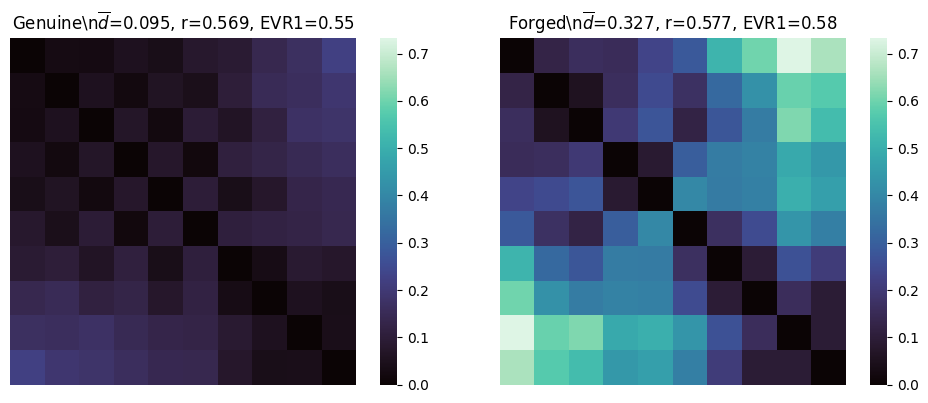

   해석:
   - 좌측(Genuine): EVR1=0.55 (낮음), 조밀한 한 덩어리
   - 우측(Forged): EVR1=0.58 (높음), 한 방향으로 길게 늘어짐
   - 공통 색 스케일로 차이가 더 명확하게 보임

🖼️ 장면 ②: 양성 bag의 극단 인스턴스 쌍 비교 (PC1 극단)


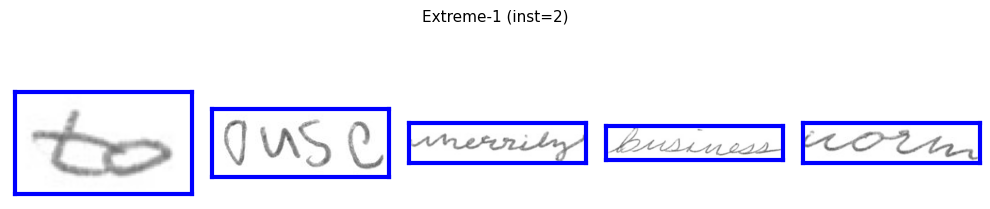

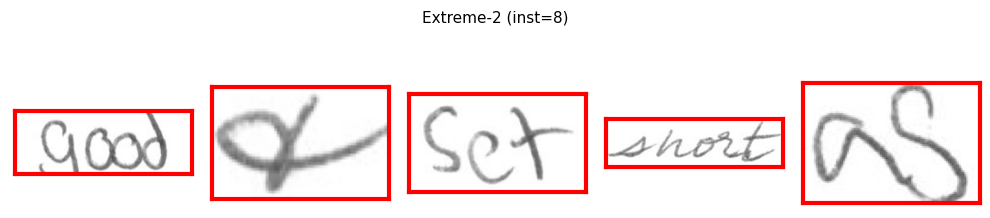

✓ saved:\n  cluster_reports/bag_1182_extreme_2.png\n  cluster_reports/bag_1182_extreme_8.png
   해석:
   - 두 행은 PC1 축에서 가장 먼 극단 인스턴스
   - 획 굵기, 기울기, 자간, 획 끝처리 차이 관찰
   - MIX 체제에서는 A-편향 vs B-편향 패턴

🔍 장면 ③: 음성 bag의 중간 거리 인스턴스 쌍 비교


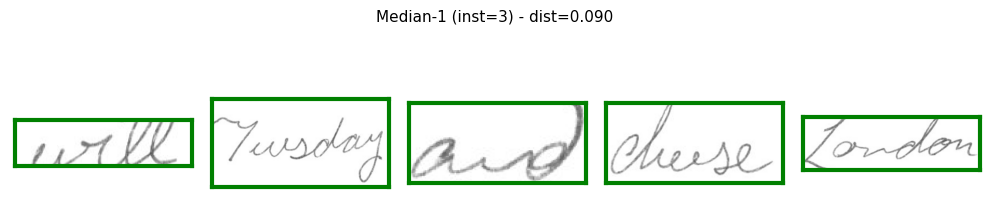

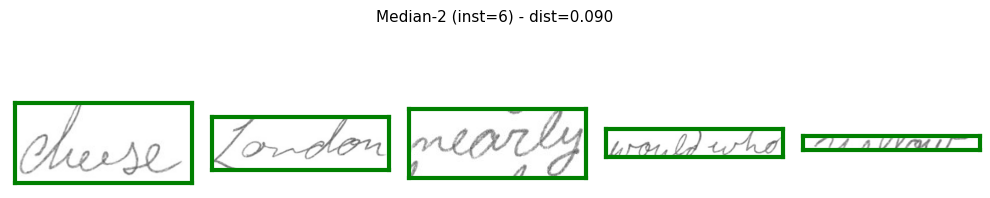

✓ saved:\n  cluster_reports/bag_576_median_3.png\n  cluster_reports/bag_576_median_6.png
중간 거리: 0.0904 (median: 0.0904, 일반적 동일 작성자 특성)
   해석:
   - 두 행은 중간 거리(median)에 해당하는 인스턴스 쌍
   - 동일 작성자의 일반적인 변동성 확인
   - 너무 가깝지도 멀지도 않은 자연스러운 차이
   - Genuine bag의 전형적 특성 파악

🔍 추가 분석: 양성 bag 최대 거리 쌍 비교 (dmax)


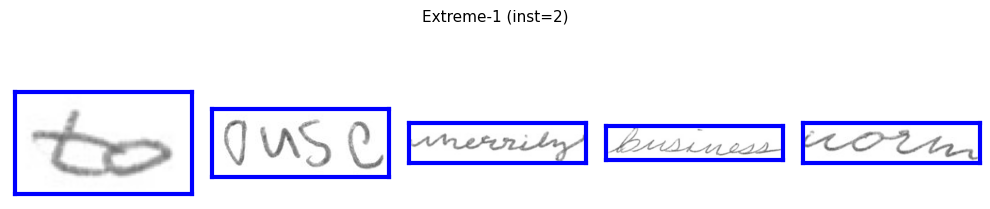

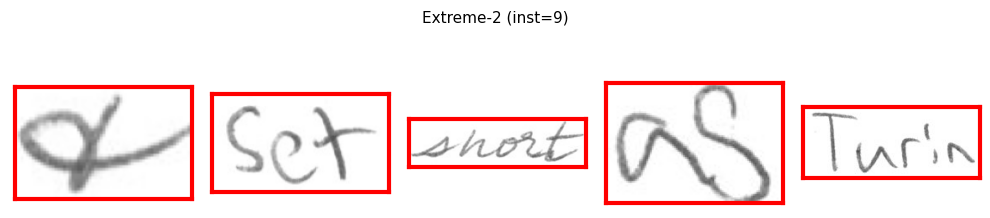

✓ saved:\n  cluster_reports/bag_1182_extreme_2.png\n  cluster_reports/bag_1182_extreme_9.png
✅ fix.md 패치 + 음성 bag 분석 완료!
   💡 개선점:
   - 공통 색 스케일로 비교 일관성 향상
   - PCA PC1 정렬로 선형 늘어짐 패턴 명확화
   - EVR1 지표로 MIX vs Genuine 구분 기준 제공
   - 극단 인스턴스 선택으로 직관적 차이 시각화
   - 음성 bag 중간 거리 쌍으로 일반적 동일 작성자 특성 확인


In [38]:
# 10. fix.md 패치가 적용된 개선된 베이스라인 분포 해석

print("🎯 fix.md 패치가 적용된 개선된 베이스라인 분포 해석을 시작합니다...")
print("   장면 ①: 공통 스케일 + PCA 정렬 + EVR1 히트맵 비교 (패치 1)")
print("   장면 ②: 양성 bag의 극단 인스턴스 쌍 이미지 비교 (패치 2,3)")
print("   장면 ③: 음성 bag의 중간 거리 인스턴스 쌍 이미지 비교 (추가)")
print()

# Best negative/positive bag 선택
best_neg, best_pos, probs = pick_best_neg_pos(model, test_features, test_labels, thr=0.5)
print("📊 선택된 bag:")
print(f"   best_neg: {best_neg}, prob: {probs[best_neg]:.4f} (낮을수록 확실한 genuine)")
print(f"   best_pos: {best_pos}, prob: {probs[best_pos]:.4f} (높을수록 확실한 forged)")
print()

if best_neg is not None and best_pos is not None:
    # 장면 ① 개선된 히트맵 (공통 스케일 + PCA 정렬 + EVR1)
    print("📈 장면 ①: 개선된 히트맵 (공통 색 스케일 + PCA 정렬 + EVR1)")
    neg_F = test_features[best_neg]  # (10, 256) 
    pos_F = test_features[best_pos]  # (10, 256)
    
    (neg_order, Dn, evr1_n), (pos_order, Dp, evr1_p) = plot_heatmaps_side_by_side_improved(
        neg_F, pos_F, metric='cosine', cmap='mako'
    )
    
    print("   해석:")
    print(f"   - 좌측(Genuine): EVR1={evr1_n:.2f} (낮음), 조밀한 한 덩어리")  
    print(f"   - 우측(Forged): EVR1={evr1_p:.2f} (높음), 한 방향으로 길게 늘어짐")
    print("   - 공통 색 스케일로 차이가 더 명확하게 보임")
    print()
    
    # 장면 ② 양성 bag 극단 인스턴스 쌍 이미지 비교 (패치 2,3)
    print("🖼️ 장면 ②: 양성 bag의 극단 인스턴스 쌍 비교 (PC1 극단)")
    show_extreme_pair_images(best_pos, test_features, metadata, 
                            image_base=IMAGE_BASE_DIR, mode='pc1')
    
    print("   해석:")
    print("   - 두 행은 PC1 축에서 가장 먼 극단 인스턴스")
    print("   - 획 굵기, 기울기, 자간, 획 끝처리 차이 관찰")
    print("   - MIX 체제에서는 A-편향 vs B-편향 패턴")
    print()
    
    # 장면 ③ 음성 bag 중간 거리 인스턴스 쌍 이미지 비교 (추가)
    print("🔍 장면 ③: 음성 bag의 중간 거리 인스턴스 쌍 비교")
    show_median_pair_images(best_neg, test_features, metadata, 
                            image_base=IMAGE_BASE_DIR, metric='cosine')
    
    print("   해석:")
    print("   - 두 행은 중간 거리(median)에 해당하는 인스턴스 쌍")
    print("   - 동일 작성자의 일반적인 변동성 확인")
    print("   - 너무 가깝지도 멀지도 않은 자연스러운 차이")
    print("   - Genuine bag의 전형적 특성 파악")
    print()
    
    # 추가: 최대 거리 쌍도 확인 (양성 bag)
    print("🔍 추가 분석: 양성 bag 최대 거리 쌍 비교 (dmax)")
    show_extreme_pair_images(best_pos, test_features, metadata, 
                            image_base=IMAGE_BASE_DIR, mode='dmax')
    
    print("✅ fix.md 패치 + 음성 bag 분석 완료!")
    print("   💡 개선점:")
    print("   - 공통 색 스케일로 비교 일관성 향상")
    print("   - PCA PC1 정렬로 선형 늘어짐 패턴 명확화")
    print("   - EVR1 지표로 MIX vs Genuine 구분 기준 제공")
    print("   - 극단 인스턴스 선택으로 직관적 차이 시각화")
    print("   - 음성 bag 중간 거리 쌍으로 일반적 동일 작성자 특성 확인")
    
else:
    print("❌ best negative 또는 best positive bag 선택 실패")
    print("   데이터나 모델 예측을 다시 확인해보세요.")